In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import gym_combrf

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
import os

import torch
import torch.optim as optim
import torch.nn.functional as F




In [3]:
#initialize gym environment
env = gym.make('combrf-v0')

In [4]:
#hyper-parameters
UPDATE_EVERY = 50 #how often to update the network
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983
EPS_STEP_LIMIT = 50

TRAIN_EPISODES = 20
TEST_EPISODES = 1
seed = 0

#initialize GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Examine state and action spaces

In [5]:
#reset the environment
obs = env.reset()

#size of each action
action_size = env.action_space.shape
print("Size of each action: ", action_size)

#size of observation
print("Size of each observation: ", obs.shape)
print("Observation looks like:")
print(obs)
print(type(env.action_space.sample()))

Size of each action:  (1,)
Size of each observation:  (1, 18)
Observation looks like:
[[-1.35685054e-06  5.40642849e-06 -5.80356396e-07 -5.80356396e-07
  -5.80356396e-07 -5.80356396e-07 -5.80356396e-07 -5.80356396e-07
  -5.80356396e-07 -5.80356396e-07  1.78224677e-06  1.78224677e-06
   1.78224677e-06  1.78224677e-06  1.78224677e-06  1.78224677e-06
   1.78224677e-06  1.78224677e-06]]
<class 'numpy.ndarray'>


## Perform random actions in the environment

In [6]:
obs = env.reset()
count = 0
ep_rwd=0
rewards =[]
actions =[]
while True:
    action = np.array([[np.random.uniform(0,1)]])
    obs, rwd, done, _ = env.step(action)
    ep_rwd += rwd
    rewards.append(rwd)
    actions.append(action)
    count +=1
    if done:
        break
print("Random TX location: {0}".format(env.tx_loc))
print("Capacity: {0}".format(env.cap))
print("Episodic score: {0} with episode length: {1} ".format(ep_rwd, count))
print(rewards)
print(actions)

Random TX location: [[-250  300    0]]
Capacity: 4.5921960668321e-08
Episodic score: 1.2 with episode length: 7 
[0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3]
[array([[0.47388085]]), array([[0.69500497]]), array([[0.90756846]]), array([[0.8517405]]), array([[0.39976107]]), array([[0.54191176]]), array([[0.03678335]])]


## Instantiate DDPG agent

In [7]:
#import custom classes
from Source.ddpg_rcv_agent import Agent
from Source.nn_model import Actor, Critic
from Source.ddpg_rcv_agent import Agent, ReplayBuffer, OUNoise
from collections import deque

#reset the environment
obs = env.reset()

state_size = obs.shape[1]
action_size = env.action_space.shape[0]
print(env.action_space.shape)
print(state_size)
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
print("Actor Local Network: {}".format(agent.actor_local))
print("Actor Target Network: {}".format(agent.actor_target))
print("Critic Local Network: {}".format(agent.critic_local))
print("Critic Target Network: {}".format(agent.critic_target))

print(type(obs))
obs_tensor = torch.from_numpy(obs).float().to(device)
print(obs_tensor)

(1,)
18
Actor Local Network: Actor(
  (fc1): Linear(in_features=18, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Actor Target Network: Actor(
  (fc1): Linear(in_features=18, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Critic Local Network: Critic(
  (fcs1): Linear(in_features=18, out_features=400, bias=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Critic Target Network: Critic(
  (fcs1): Linear(in_features=18, out_features=400, bias=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
<class 'numpy.ndarray'>
tensor([[-5.5723e-08, -4.2122e-08, -5.9707e-08, -1.3780e-07,  1.0684e-07,
          1.0126e-07, -1.4147e-07,

In [8]:
agent.reset()

In [9]:
obs = env.reset()

print(env.action_space.sample())
action = agent.act(obs)
print(action)

[5.8951707]
[[0.2014815]]


## DDPG Training

Episode 100	Average Score: 0.83
Episode actions: [array([[-0.82054627]], dtype=float32), array([[-0.7190709]], dtype=float32), array([[-0.6652782]], dtype=float32), array([[-0.65009564]], dtype=float32), array([[-0.6154922]], dtype=float32), array([[-0.66425693]], dtype=float32), array([[-0.60846835]], dtype=float32)]
Episode env actions: [array([0.56377052]), array([0.88256476]), array([1.05155956]), array([1.09925696]), array([1.2079668]), array([1.05476796]), array([1.23003294])]
Episode 200	Average Score: 1.06
Episode actions: [array([[-0.83940727]], dtype=float32), array([[-0.79719096]], dtype=float32), array([[-0.80600667]], dtype=float32), array([[-0.77360535]], dtype=float32), array([[-0.65108913]], dtype=float32), array([[-0.5381761]], dtype=float32), array([[-0.60490334]], dtype=float32)]
Episode env actions: [array([0.50451696]), array([0.63714338]), array([0.60944802]), array([0.71123978]), array([1.09613582]), array([1.45086251]), array([1.24123276])]
Episode 300	Average S

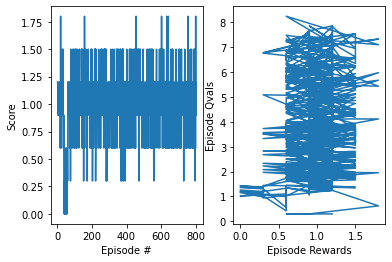

In [10]:
train_episodes = 800
print_every= 100

scores_deque = deque(maxlen=print_every)
scores = []
ep_qvals =[]
timestep = 0
for i_episode in range(1,train_episodes+1):
    
    # reset the environment
    obs = env.reset()
    agent.reset()
    ep_rwds = []
    ep_actions =[]
    ep_env_actions =[]
    score = 0
    ep_qval = 0
    while True:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.step(obs, action, reward, next_obs, done)
        obs = next_obs
        score+= reward
        timestep+=1
        
        agent.critic_local.eval()
        obs_tensor = torch.from_numpy(obs).float().to(device)
        action_tensor = torch.from_numpy(action).float().to(device)
        #print(agent.critic_local(obs_tensor, action_tensor).cpu().data.item())
        ep_qval += agent.critic_local(obs_tensor, action_tensor).cpu().data.item()
        agent.critic_local.train()
        
        ep_rwds.append(reward)
        ep_actions.append(action)
        ep_env_actions.append(env.action)
        #ep_old_actions.append(agent.old_action)
        if done:
            break
            
    scores_deque.append(score)
    scores.append(score)
    ep_qvals.append(ep_qval)
    #print('\rEpisode {}\t, TX loc: {}\t, Score: {:.2f}\n'.format(i_episode, env.tx_loc, score), end="")
    
    #print(ep_rwds)
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        #print("Episode old_actions: {}".format(ep_old_actions))
        print("Episode actions: {}".format(ep_actions))
        print("Episode env actions: {}".format(ep_env_actions))
        
#torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')    
agent.save_checkpoint(timestep)

fig = plt.figure()
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

ax2 = fig.add_subplot(122)
plt.plot(scores, ep_qvals)
plt.ylabel('Episode Qvals')
plt.xlabel('Episode Rewards')
plt.show() 

In [11]:
print(ep_qvals[0])
print(ep_qval)

0.29940303042531013
6.954927682876587


## Testing the DDPG agent

In [23]:
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

agent.load_checkpoint(timestep)

score = 0.0
eps_rwd =[]
test_obs =[]
obs = env.reset()
#agent.reset()
agent.actor_local.eval()
agent.critic_local.eval()
agent.actor_target.eval()
agent.critic_target.eval()
ep_actions =[]
ep_old_actions =[]
tx_dirs =[]
rx_dirs=[]
data_rates =[]
while True:
    #obs_tensor = torch.from_numpy(obs).float().to(device)
    
    #with torch.no_grad():
    #    action =agent.actor_local(obs_tensor).cpu().data.numpy()
        #print("old_action: {}", action)
    #    best_action = agent.critic_local(obs_tensor)
    test_obs.append(obs)
    action =  agent.act(obs,add_noise=False)#.cpu().data.numpy()
    #action == np.clip(action, 0, 2*np.pi)
    
    #action_tensor = agent.actor_local(obs_tensor).to(device)
    #print(obs, action)
    #q_val = agent.critic_local(obs_tensor, action_tensor).cpu().data.numpy()
    tx_dirs.append(env.tx_bdir)
    rx_dirs.append(env.rx_bdir)
    data_rates.append(env.rate)
    
    obs, rwd, done, _ = env.step(action)
    
    score +=rwd
    eps_rwd.append(rwd)
    if done:
        break
print("TX loc: {0}".format(env.tx_loc))

print("TX_ dirs: {}".format(tx_dirs))
print("RX_dirs: {}".format(rx_dirs))

print("eps rwds: {}\n".format(eps_rwd))



TX loc: [[-250  100    0]]
TX_ dirs: [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]
RX_dirs: [5.9900875, 3.7450702829239286e-07, 3.7450702829239286e-07, 3.7450702829239286e-07, 3.7450702829239286e-07, 3.7450702829239286e-07, 3.7450702829239286e-07]
eps rwds: [0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



In [13]:
print(test_obs)

[array([[-8.84120467e-07, -3.91539456e-07, -3.92929823e-07,
        -3.92929823e-07, -3.92929823e-07, -3.92929823e-07,
        -3.92929823e-07, -3.92929823e-07, -3.92929823e-07,
        -3.92929823e-07,  1.25013278e-07,  1.25013278e-07,
         1.25013278e-07,  1.25013278e-07,  1.25013278e-07,
         1.25013278e-07,  1.25013278e-07,  1.25013278e-07]]), array([[-6.52858066e-11, -6.01379739e-11, -3.92929823e-07,
        -3.92929823e-07, -3.92929823e-07, -3.92929823e-07,
        -3.92929823e-07, -3.92929823e-07, -3.92929823e-07,
        -3.92929823e-07,  1.25013278e-07,  1.25013278e-07,
         1.25013278e-07,  1.25013278e-07,  1.25013278e-07,
         1.25013278e-07,  1.25013278e-07,  1.25013278e-07]]), array([[-6.52858066e-11, -6.01379739e-11, -3.92929823e-07,
        -3.92929823e-07, -3.92929823e-07, -3.92929823e-07,
        -3.92929823e-07, -3.92929823e-07, -3.92929823e-07,
        -3.92929823e-07,  1.25013278e-07,  1.25013278e-07,
         1.25013278e-07,  1.25013278e-07,  1.2501

In [14]:
from Source.misc_fun.utils import plotbeam
print(env.channel.az_aod[0])
print(ep_actions[-1][0])
tx_theta, tx_gr = plotbeam(env.channel.az_aod[0], env.N_tx)
rx_theta, rx_gr = plotbeam(ep_actions[-1][0], env.N_rx)
ax1 = plt.subplot(121, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(122, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()


4.71238898038469


IndexError: list index out of range